Copied from Kaggle:

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

# Import Libraries, read in Kaggle data & features from other sources

In [2]:
# Importing the libraries and datasets.
# Does not yet inclue Theano libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
#from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
#from sklearn.cross_validation import cross_val_score
#from sklearn.cross_validation import KFold
from sklearn import cross_validation
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import explained_variance_score
import copy
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
import statsmodels.api as sm
%matplotlib inline


# The Kaggle data
full = pd.read_csv('~/datasets/bikeshare/train.csv')
test = pd.read_csv('~/datasets/bikeshare/test.csv')

# External Datasets
wmata_delay=pd.read_csv('~/datasets/bikeshare/wmata_delay_wrangled.csv')
light_data=pd.read_csv('~/datasets/bikeshare/WeatherObsDCNoPrecip.csv')
time_series=pd.read_csv('~/datasets/bikeshare/Time_Series_formatted.csv')

print(full.shape)
print(test.shape)
print(wmata_delay.shape)
print(light_data.shape)
print(time_series.shape)

(10886, 12)
(6493, 9)
(14257, 8)
(17544, 25)
(104, 4)


In [63]:
# Here is the funtion to evaluate Root Mean Square Logarithmic Error (RMSLE) for regression analysis

def rmsle(y, y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))


# Let's look at what we have to work with: Full training data from Kaggle

In [4]:
# Let's take a look at the training data from Kaggle.

print(list(full))
print(full.dtypes)

['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']
datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object


# Generating the Baseline

To generate a baseline, we are calculating the average number of total riders per hour, across every day.  This was our baseline submission, using mean ridership per hour as the baseline.

The date/time stamp from Kaggle has good information, but not in this form.  We expect that the hour of the day will be correlated with the number of riders, both casual and registered. We also think that the day of the week may have more predictive power than just "weekday" or "weekend".  Let's extract as much information from the datetime stamp as possible.

In [10]:
# Separating the datetime field into separate date and time (hour) columns for train and test.
full["date"] = full.datetime.apply(lambda x : x.split()[0])
full["hour"] = full.datetime.apply(lambda x : x.split()[1].split(":")[0])

test["date"] = test.datetime.apply(lambda x : x.split()[0])
test["hour"] = test.datetime.apply(lambda x : x.split()[1].split(":")[0])

full.hour = full.hour.astype(int)
test.hour = test.hour.astype(int)

#  Calculate the hourly averages and save as "averages"
averages = full.groupby(['hour']).mean()

# Only save the appropriate columns
averages = averages.ix[:,'casual':]

# Rename the index, and adding the hours column
averages.index.names = ['index']
hour = {'hour': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]}
df_hour = pd.DataFrame(hour, columns = ['hour'])
averages = pd.merge(averages, df_hour, right_index=True, left_index=True)

# Here is the resulting dataset - the average number of riders per hour, across all days.
print('Information on the Baseline Calculations:')
print(averages.dtypes)
print(averages[:5])
print("===========================================")
print()

# Now we need to use a join function to insert the average riders per day,
# to predict the test set.

submission = test.merge(averages, on='hour')
submission = submission.drop(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'date', 'hour', 'casual', 'registered'], axis=1)
submission = submission.set_index('datetime')
print('Information on the Baseline Submission:')
print(submission.dtypes)
print(submission[:5])

# Printing to text file
# This is our baseline submission

submission.to_csv('~/datasets/bikeshare/average_usage_baseline.csv', sep=',')

Information on the Baseline Calculations:
casual        float64
registered    float64
count         float64
hour            int64
dtype: object
          casual  registered      count  hour
index                                        
0      10.312088   44.826374  55.138462     0
1       6.513216   27.345815  33.859031     1
2       4.819196   18.080357  22.899554     2
3       2.681293    9.076212  11.757506     3
4       1.262443    5.144796   6.407240     4

Information on the Baseline Submission:
count    float64
dtype: object
                         count
datetime                      
2011-01-20 00:00:00  55.138462
2011-01-21 00:00:00  55.138462
2011-01-22 00:00:00  55.138462
2011-01-23 00:00:00  55.138462
2011-01-24 00:00:00  55.138462


# Plotting the Data

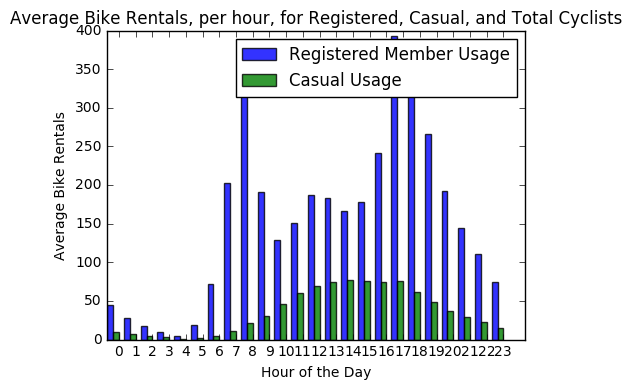

In [11]:
# Let's plot the data
n_groups = 24
casual = averages['casual']
registered = averages['registered']
 
# Create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, registered, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Registered Member Usage')
 
rects2 = plt.bar(index + bar_width, casual, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Casual Usage')
 
plt.xlabel('Hour of the Day')
plt.ylabel('Average Bike Rentals')
plt.title('Average Bike Rentals, per hour, for Registered, Casual, and Total Cyclists')
plt.xticks(index + 2*bar_width, index)
plt.legend()
 
plt.tight_layout()
plt.show()

# Let's look at external datasets which may provide additional information:

1. External Light and Weather Data
2. Mass Transit Data (from WMATA)
3. Additional Light and Weather Information from timeanddate.com
4. Calculating prior hour's weather information as a new feature for each observation

# External Light and Weather Data

In [12]:
# Let's look at the additional features we engineered about light and weather
#
# Source for 2011 Weather Data: https://www1.ncdc.noaa.gov/pub/data/noaa/2011/724050-13743-2011.gz
# Source for 2012 Weather Data: https://www1.ncdc.noaa.gov/pub/data/noaa/2012/724050-13743-2012.gz
# USAF Weather Station: 724050
# WBAN Weather Station Code: 13743
#
# This weather is for Regan International Airport, the closest weather station to Washington DC
#
# Also added daylight information
# 
# Source for light data: https://www.timeanddate.com/sun/usa/washington-dc?month=12&year=2011
# 
# The API was $50.00, so cut and pasted the data for each month from the site above 
# (reference link is for December, 2011 -- only one month of data was displayed at a time)
#
# Daylight was defined using Nautical Twilight and sunrise/sunset as follows:
#
# Hours before morning Nautical Twilight or after evening Nautical Twilight are consdiered Dark
# Hours after sunrise and before sunset are considered Light
# Hours that have at least 15 minutes that occur between am Nautical Twilight and sunrise or 
# sunset and pm Nautical Twilight are considered Twilight
#
# The theory is that people will be more likely to rent a bike when it is light.  Hour of day 
# can't be used b/c of seasonality in light and daylight savings time we will see if this adds anything!

print("Fields for addl light and weather features")
print("===========================================")
print(light_data.dtypes)
print("===========================================")
print()

# we don't need the quality control columns, as those were for checking the excel
# we also renamed the light/dark/twighlight features, so we don't need the duplicates
# We also have binarized some of the data, so we don't need the source fields

light_data = light_data.drop(['dayOfWeekQC', 'LightQC', 'dayOfWeek', 'light'], axis=1)
light_data.hour = light_data.hour.astype(np.int32)

# Now lets see what we have again

print("Updated Fields for addl light and weather features")
print("===========================================")
print(list(light_data))
print("===========================================")
print(light_data.dtypes)

#----------I'm getting errors in this cell...I think it's because I reran after the columns were removed.

Fields for addl light and weather features
year                   int64
month                  int64
day                    int64
yyyymmdd               int64
date                  object
dayNum                 int64
dayOfWeek              int64
isSun                  int64
isMon                  int64
isTues                 int64
isWeds                 int64
isThurs                int64
isFri                  int64
isSat                  int64
dayOfWeekQC            int64
hour                   int64
light                 object
isLight                int64
isDark                 int64
isTwilight             int64
LightQC                int64
ceilingHeight          int64
visibilityDistance     int64
dewPoint               int64
seaLevelPressure       int64
dtype: object

Updated Fields for addl light and weather features
['year', 'month', 'day', 'yyyymmdd', 'date', 'dayNum', 'isSun', 'isMon', 'isTues', 'isWeds', 'isThurs', 'isFri', 'isSat', 'hour', 'isLight', 'isDark', 'isTwilight', '

# Adding Additional Features from Data

In [13]:
###############################################################################################
# Next two features I had problems coding, so engineered them in excel and merged in with Light data
#
# dayOfWeek and dayNum -- a rising column incremented by 1 for each day
###############################################################################################

# Weekday feature extraction to be added -- code not working, so engineered in Excel (see above)
# in accordance with permission granted in email.
#
# Python treats x as a string, so we can't use datetime functions on it, but
# when passed, it appears to be passed as a datetime object
# Code commented out due to errors

# train["dayOfWeek"] = train.datetime.apply(lambda x: datetime.strptime(x,'%w'))

# Rising daynum to be added -- code not working  -- code not working, so engineered in Excel (see above)
# in accordance with permission granted in email.
#
# Python treats x as a string, so we can't use datetime functions on it, but
# when passed, it appears to be passed as a datetime object
# Code commented out due to errors -- this sample done as the other way it breaks
# We don't want to run a for loop, but can't seem to find the correct approach

# train["dayNum"] = train.datetime.apply(lambda x: x.to_ordinal())
#
# This problem was solved by adding these fields to the additional Weather Observations see merge
# of light_data below -- Explanation of how data derived in first tab of .xlsx 

print('For the full/training dataset:')
print("===========================================")
print(full.shape)
print("===========================================")
print(list(full))
print("===========================================")
print(full.dtypes)
print()
print()
print('For the test dataset:')
print("===========================================")
print(test.shape)
print("===========================================")
print(list(test))
print("===========================================")
print(test.dtypes)

For the full/training dataset:
(10886, 14)
['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count', 'date', 'hour']
datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
date           object
hour            int32
dtype: object


For the test dataset:
(6493, 11)
['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'date', 'hour']
datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
date           object
hour            int32
dtype: object


# Merge in Partial Mass Transit Data

In [14]:
# We believe that delays in mass transit could cause more people to ride bikes
# So we found a data source (WMATA). However, the data is only available for the last 9 months
# of our time period.

print("From the external dataset from WMATA: Washington Metropolitan Area Transit Authority:")
print("===========================================")
print(wmata_delay.dtypes)
print("===========================================")
print()
print()

# Merging in external data from DC Metro (WMATA).
# Let's see if transit delays/outages affect cycling ridership in our bikeshare data. 

fullWithWMATA = pd.merge(full, wmata_delay, how='left', left_on=['date','hour'], right_on = ['date','hour'])
fullWithWMATA.drop_duplicates(['datetime'], keep='last')
testWithWMATA = pd.merge(test, wmata_delay, how='left', left_on=['date','hour'], right_on = ['date','hour'])
testWithWMATA.drop_duplicates(['datetime'], keep='last')

## The delay_collapsed variable is the one we are using for this analysis (will delays affected bikeshare ridership?).
## Only 10% of the hours in our dataset had metro delays so the rest are 
# merged in as NaN. We replace those with 0.

fullWithWMATA['delay_collapsed']=fullWithWMATA['delay_collapsed'].fillna(0)
testWithWMATA['delay_collapsed']=testWithWMATA['delay_collapsed'].fillna(0)

# Print what the new datasets look like:

print("The merged dataset - training plus WMATA:")
print("===========================================")
print(fullWithWMATA.shape)
print("===========================================")
print(fullWithWMATA.dtypes)
print("===========================================")
print()
print("The merged dataset - test plus WMATA:")
print("===========================================")
print(testWithWMATA.shape)
print("===========================================")
print(testWithWMATA.dtypes)
print("===========================================")

# Export to csv.
fullWithWMATA.to_csv('~/datasets/bikeshare/merge_wmata_full_data_test.csv', sep=',')
testWithWMATA.to_csv('~/datasets/bikeshare/merge_wmata_test_data_test.csv', sep=',')

#------------------> Why dont we drop the columns that we aren't using?


From the external dataset from WMATA: Washington Metropolitan Area Transit Authority:
date                object
hour                 int64
Incident            object
Line                object
Direction           object
Cause               object
Delay              float64
delay_collapsed    float64
dtype: object


The merged dataset - training plus WMATA:
(10886, 20)
datetime            object
season               int64
holiday              int64
workingday           int64
weather              int64
temp               float64
atemp              float64
humidity             int64
windspeed          float64
casual               int64
registered           int64
count                int64
date                object
hour                 int32
Incident            object
Line                object
Direction           object
Cause               object
Delay              float64
delay_collapsed    float64
dtype: object

The merged dataset - test plus WMATA:
(6493, 17)
datetime            obje

# Merge in light data and other weather variables

In [15]:
# We believe that the light might make a difference to ridership
# Using data from timeanddate.com, we have calculated each hour as being light, dark or twilight
# Using nautical twilight as the guide, we designated an hour as twilight if it had at least 15 minutes of twilight
# during it.  Daytime was the hours between sunrise and sunset, and Dark was the time between nautical twilight
# in the eve and nautical twilisght in the morning.
#
# This resulted in 1 or two hours each morning and night being considered twilight
# Data was copy and pasted into excel and then wrangled there

# This cell is to merge that data into our dataset

fullWithExtFeats = pd.merge(fullWithWMATA, light_data, how='left', left_on=['date','hour'], right_on = ['date','hour'])
testWithExtFeats = pd.merge(testWithWMATA, light_data, how='left', left_on=['date','hour'], right_on = ['date','hour'])

# Let's see what the data looks like now:
print("The merged dataset - training, plus WMATA and TimeAndDate.com:")
print("===========================================")
print(fullWithExtFeats.shape)
print("===========================================")
print(fullWithExtFeats.dtypes)
print("===========================================")
print()
print("The merged dataset - test, plus WMATA and TimeAndDate.com:")
print("===========================================")
print(testWithExtFeats.shape)
print("===========================================")
print(testWithExtFeats.dtypes)
print("===========================================")

# Export to CSV:
fullWithExtFeats.to_csv('~/datasets/bikeshare/merge_light_full_data.csv', sep=',')
testWithExtFeats.to_csv('~/datasets/bikeshare/merge_light_test_data.csv', sep=',')


The merged dataset - training, plus WMATA and TimeAndDate.com:
(10886, 39)
datetime               object
season                  int64
holiday                 int64
workingday              int64
weather                 int64
temp                  float64
atemp                 float64
humidity                int64
windspeed             float64
casual                  int64
registered              int64
count                   int64
date                   object
hour                    int32
Incident               object
Line                   object
Direction              object
Cause                  object
Delay                 float64
delay_collapsed       float64
year                    int64
month                   int64
day                     int64
yyyymmdd                int64
dayNum                  int64
isSun                   int64
isMon                   int64
isTues                  int64
isWeds                  int64
isThurs                 int64
isFri                   i

# Add the prior hour's weather as a feature of each observation

In [16]:
###########################################
# Now that we have a fully merged dataset with all the engineered features, 
# we want to add some of the prior hour's information, and two hours before,
# but then we have to deal with missing observations
#
# There are 42 missing observations in the full training data for the days we are looking at
# and, additionally, all days from the end of the month are missing, since they are in the test
# set so the first observation (midnight) for the first of the month for every month will be missing.
#
# Proposed approach is to average fields that can be averaged: temp, atemp, humidity, and windspeed 
# as well as the continuous variables from the weather data.
# The weather code will be assumed to be the "worse" value if the hour before and the hour after have 
# different weather codes.
########################

####################################################
# Method:
# 
# The training and test data together make continuous observations.  Upon manual review in excel, there are no 
# two consecutive missing values when the two datasets are taken together. Since this information is "hard" or 
# "actual features" and we are not changing that data at all, we can use it to create the "previous hour's" data
# as long as we do not modify the core original features.
#
# The first thing we have to do is append the test and train datasets:
#
fullWithExtFeats['isTrain']=1
testWithExtFeats['isTrain']=0

f_and_tWEF=fullWithExtFeats.append(testWithExtFeats)
sortedDF = f_and_tWEF.sort_values('datetime')

# print(sortedDF.shape)
# print(sortedDF[:5])
# print("\n\nPrint some test records to make sure the data is sorted properly\n")
# print(sortedDF[504:509])

# Now we need to create the columns for the previous hour's weather

print(list(sortedDF))

# populate with the earlier record
# note EDA (in excel) showed that there were no two consecutive missing observations, so we are
# OK using the prior record even with some missing obs, because we are willing to use the date
# from two hours before when the hour before is missing.

sortedDF['prev_atemp']=sortedDF.atemp.shift()
sortedDF['prev_ceilingHeight']=sortedDF.ceilingHeight.shift()
sortedDF['prev_dewPoint']=sortedDF.dewPoint.shift()
sortedDF['prev_humidity']=sortedDF.humidity.shift()
sortedDF['prev_seaLevelPressure']=sortedDF.seaLevelPressure.shift()
sortedDF['prev_temp']=sortedDF.temp.shift()
sortedDF['prev_visibilityDistance']=sortedDF.visibilityDistance.shift()
sortedDF['prev_weather']=sortedDF.weather.shift()
sortedDF['prev_windspeed']=sortedDF.windspeed.shift()

# We need to fill in the first value now so there are no nan. We will just replace it with the second value
filter_col = [col for col in list(sortedDF) if col.startswith('prev_')]
print(filter_col)

for col in filter_col:
    
    test_value=sortedDF[col].iloc[[0]].values
    test_value1=test_value[0]
    
    
    if np.isnan(test_value1):
        #print(sortedDF[col].iloc[[0]], "look here")
        replacement_value=sortedDF[col].iloc[[1]].values
        replacement_value1=replacement_value.tolist()
        
        replacement_value2=replacement_value1[0]
        
        sortedDF.loc[0,col] = replacement_value2
    else:
        print("Not missing")
        
# Now we have to split the data back into test and train

train_mask=sortedDF['isTrain']==1
test_mask=sortedDF['isTrain']==0

sortedFull=sortedDF[train_mask]
sortedTest=sortedDF[test_mask]

print("The training data, :")
print("===========================================")
print(sortedFull.dtypes)
print(sortedFull.shape)
print("===========================================")
print(sortedFull[:5])
print()

print("The test data, :")
print("===========================================")
print(sortedTest.dtypes)
print(sortedTest.shape)
print("===========================================")
print(sortedTest[:5])
print()

sortedFull.to_csv('~/datasets/bikeshare/sortedFull.csv', sep=',')
sortedTest.to_csv('~/datasets/bikeshare/sortedTest.csv', sep=',')


['Cause', 'Delay', 'Direction', 'Incident', 'Line', 'atemp', 'casual', 'ceilingHeight', 'count', 'date', 'datetime', 'day', 'dayNum', 'delay_collapsed', 'dewPoint', 'holiday', 'hour', 'humidity', 'isDark', 'isFri', 'isLight', 'isMon', 'isSat', 'isSun', 'isThurs', 'isTrain', 'isTues', 'isTwilight', 'isWeds', 'month', 'registered', 'seaLevelPressure', 'season', 'temp', 'visibilityDistance', 'weather', 'windspeed', 'workingday', 'year', 'yyyymmdd']
['prev_atemp', 'prev_ceilingHeight', 'prev_dewPoint', 'prev_humidity', 'prev_seaLevelPressure', 'prev_temp', 'prev_visibilityDistance', 'prev_weather', 'prev_windspeed']
The training data, :
Cause                       object
Delay                      float64
Direction                   object
Incident                    object
Line                        object
atemp                      float64
casual                     float64
ceilingHeight                int64
count                      float64
date                        object
datetime 

# Basic Exploratory Data Analysis 

Ideas:

Weekday/Weekend/Holiday - Extracting 'Day of Week' from datetime and see if there is a difference.
Hypothesis - Casual Riders will increase during the weekend due to recreational habits, and 
registered riders will decrease due to assumption that registered riders use bikes to commute.

Weather - Which of the weather factors affect rider numbers, if any?  

Season/Holiday - Which, if any, seasons affect rider numbers?  In DC, the nicest weather is spring and fall - is this
represented in the data?  Summer is very, very hot, so I would assume registered riders would use the service in the 
evening commute, and casual riders would increase in the spring/summer, since those are the heaviest tourist seasons.

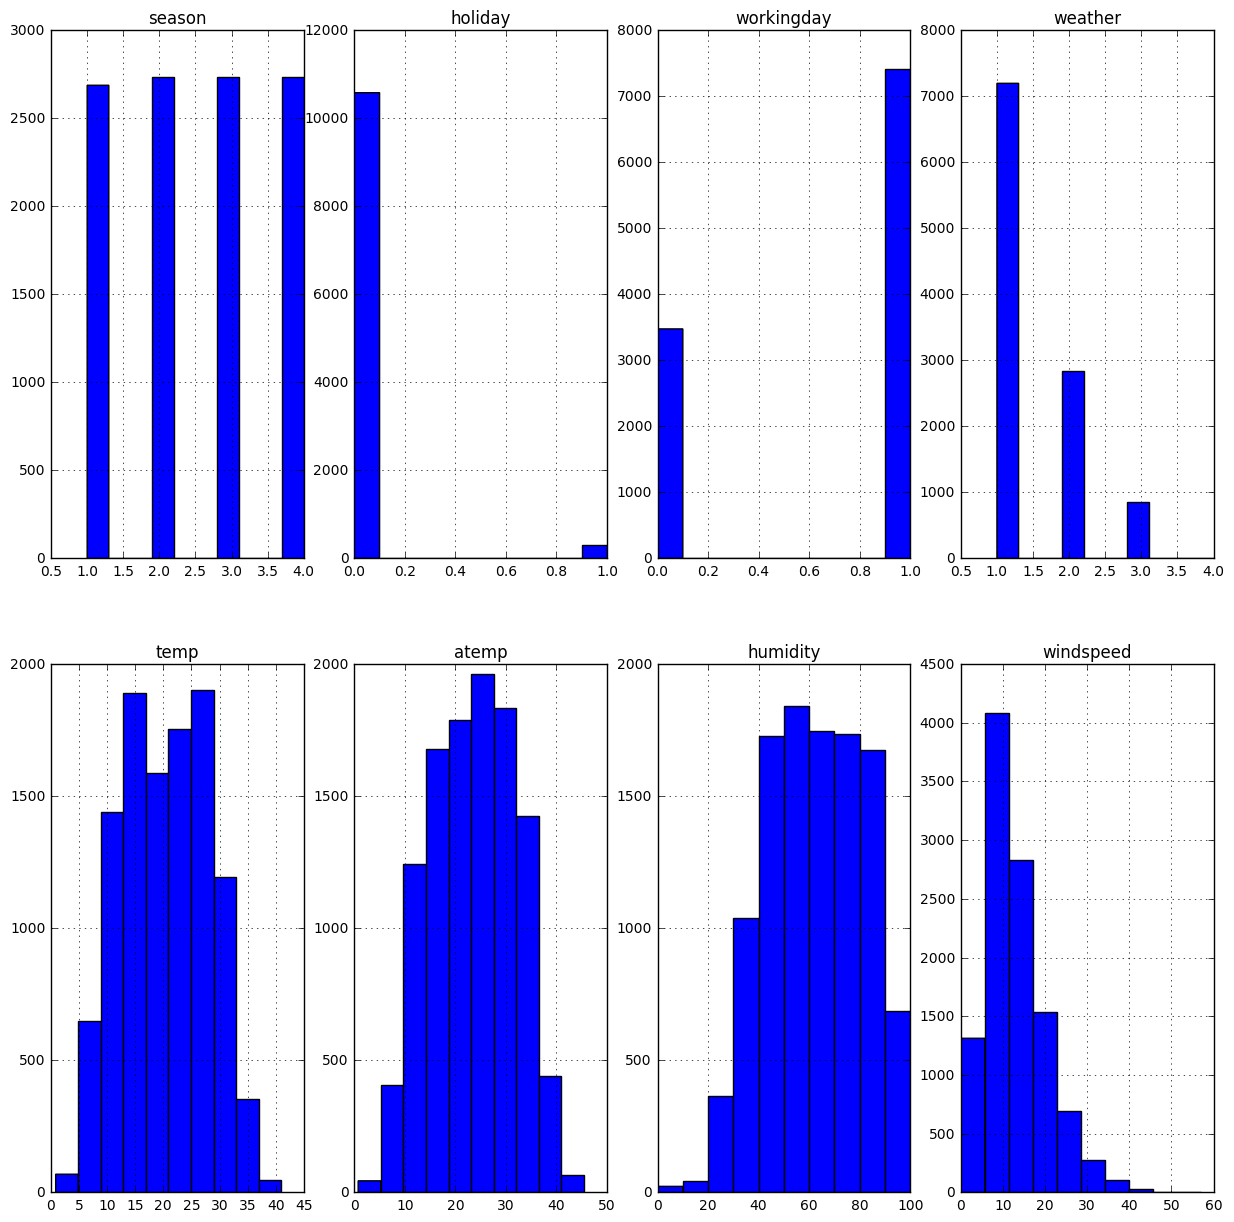

In [17]:
#Basic EDA, we can expand beyond these eight variables, now that the data is fully merged.
# Now, we need to figure out which variables affect ridership the most,
# thereby determining which factors are best to use for our model.
# Here are histograms of 8 different variables.

num_vars=['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']
plt.figure(figsize=(15,15), dpi=150)
for i, var in enumerate(num_vars):
    j=i+1
    plt.subplot(2,4,j) 
    full[var].hist()
    plt.title(var)

The histograms reveal that season is almost equal distribution, which makes sense, since this is timeseries data, and the seasons are each about the same length (count per season might be more informative) weather type 1 (Clear, Few clouds, Partly cloudy, Partly cloudy) is dominant, atemp appears to be normally distributed with a peak riding temperate of about 25 degrees and windspeed appears to be inversely correlated with ridership.

# Basic Regression Analysis

In [14]:
# Keep this random seed here to make comparison easier.
np.random.seed(785)

# Dividing our training data into training and development sets.
msk = np.random.rand(len(full)) < 0.8
train = fullWithWMATA[msk]
dev=fullWithWMATA[~msk]
print ('Training set shape: ', train.shape)
print ('Dev set  shape: ', dev.shape)

Training set shape:  (8715, 20)
Dev set  shape:  (2171, 20)


In [15]:
#  What are the best variable(s) for registered cyclists?

registered_report=[]
for var in num_vars:
    X_train = train[var]
    X_dev = dev[var]

    Y_train = train['registered']
    Y_dev = dev['registered']

    X_train1=X_train.values.reshape(-1, 1)
    Y_train1=Y_train.values.reshape(-1, 1)
    Y_dev1=Y_dev.values.reshape(-1, 1)
    X_dev1=X_dev.values.reshape(-1, 1)


    # Create linear regression object
    #regr = linear_model.LinearRegression() (Jordan...I got an error doing this...)
    #So I modified to this... is this correct?  
    regr = linear_model.LinearRegression()
    
    # Train the model using the training sets
    regr.fit(X_train1, Y_train1)
    preds = regr.predict(Y_dev1)

    # The coefficients
    #print('Coefficients: \n', regr.coef_[0][0])
    coef=regr.coef_[0][0]
    
    # The mean squared error
    #print("Mean squared error: %.2f"
         # % np.mean((preds) - Y_dev1) ** 2)
    mse=int(np.mean((preds) - Y_dev1) ** 2)
    
    # Explained variance score: 1 is perfect prediction
    #print('Variance score: %.2f' % regr.score(X_dev1, Y_dev1))
    var_score=regr.score(X_dev1, Y_dev1)
    registered_report.append([var, coef, mse, var_score])

print ("For registered cyclists:")
print ("Variable, coefficient, MSE, Variable score")
for i in registered_report:
    print( i)
print('_____________________________________________________________________')   
    
#  What are the best variable(s) for casual cyclists?

casual_report=[]
for var in num_vars:
    X_train = train[var]
    X_dev = dev[var]

    Y_train = train['casual']
    Y_dev = dev['casual']

    X_train1=X_train.values.reshape(-1, 1)
    Y_train1=Y_train.values.reshape(-1, 1)
    Y_dev1=Y_dev.values.reshape(-1, 1)
    X_dev1=X_dev.values.reshape(-1, 1)


    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train1, Y_train1)

    preds = regr.predict(Y_dev1)
    # The coefficients
    #print('Coefficients: \n', regr.coef_[0][0])
    coef=regr.coef_[0][0]
    # The mean squared error
    #print("Mean squared error: %.2f"
         # % np.mean((preds) - Y_dev1) ** 2)
    mse=int(np.mean((preds) - Y_dev1) ** 2)
    # Explained variance score: 1 is perfect prediction

    #print('Variance score: %.2f' % regr.score(X_dev1, Y_dev1))
    var_score=regr.score(X_dev1, Y_dev1)
    
    casual_report.append([var, coef, mse, var_score])

print ("For casual cyclists:")
print ("Variable, coefficient, MSE, Variable score")
for i in casual_report:
    print( i)

For registered cyclists:
Variable, coefficient, MSE, Variable score
['season', 22.346629555687997, 11810880, 0.026044630275451564]
['holiday', -19.039184998659231, 8862700, 0.00042761760039833341]
['workingday', 39.325073290646024, 37457871, 0.012359691610277057]
['weather', -24.167930005477306, 14026235, 0.01845181800144835]
['temp', 6.1295060692318355, 693818, 0.10875595788307968]
['atemp', 5.5356287821314147, 537581, 0.11027371954497277]
['humidity', -2.0848319580928605, 39193, 0.071878209711964791]
['windspeed', 1.7391023263732592, 61785, 0.0060854281445765768]
_____________________________________________________________________
For casual cyclists:
Variable, coefficient, MSE, Variable score
['season', 4.3438850570713967, 22404, 0.0073813127152221325]
['holiday', 11.957335128644457, 197612, 0.0019757421557516919]
['workingday', -33.232403847075147, 1488386, 0.10946339550393036]
['weather', -10.583710750707986, 145837, 0.017307608948005981]
['temp', 2.9583504949463855, 2382, 0.2143

We found that temperature is the most predictive basic feature for both registered and casual riders based on the variance score but this is not consistent with the mean square error.

# Time Series Analysis

In [16]:
# Ridership increases over time, so we wanted to analyze that and see what we could find
# 
###time series regression, make the dataframes
##wanted to do by week but the fact that the last week of each month is omitted is problematic. 
# from datetime import datetime -- imported in first cell

##make a train set by week
trainTS = train.drop(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'datetime', 'hour', 'casual', 'registered'], axis=1)
trainTS["date1"] =[datetime.strptime(i , '%Y-%m-%d') for i in trainTS["date"] ]
trainTS.index=trainTS['date1']


trainByWeek=trainTS.groupby([lambda x: x.year, lambda x: x.month, lambda x: x.week]).sum()


##make a dev set by month
devTS = dev.drop(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'datetime', 'hour', 'casual', 'registered'], axis=1)
devTS["date1"] =[datetime.strptime(i , '%Y-%m-%d') for i in devTS["date"] ]
devTS.index=devTS['date1']


devByWeek=devTS.groupby([lambda x: x.year, lambda x: x.month, lambda x: x.week]).sum()
print(type(trainByWeek))
trainByWeek.values.tolist()
print(trainByWeek)

<class 'pandas.core.frame.DataFrame'>
            count  Delay  delay_collapsed
2011 1  1    8017    NaN              0.0
        2    6573    NaN              0.0
        3    2950    NaN              0.0
        52   1450    NaN              0.0
     2  5    7019    NaN              0.0
        6    8892    NaN              0.0
        7   10560    NaN              0.0
     3  9    8379    NaN              0.0
        10   9890    NaN              0.0
        11  12594    NaN              0.0
     4  13   6802    NaN              0.0
        14  13734    NaN              0.0
        15  14559    NaN              0.0
        16   4967    NaN              0.0
     5  17   2112    NaN              0.0
        18  23422    NaN              0.0
        19  24909    NaN              0.0
        20  12500    NaN              0.0
     6  22  20022    NaN              0.0
        23  26212    NaN              0.0
        24  26309    NaN              0.0
     7  26  10356    NaN              

In [17]:
###Establish baseline of performance
# imports consolidated into first cell
# from sklearn.metrics import mean_squared_error
# from math import sqrt
# walk-forward validation
trainByWeek = trainByWeek.astype('float32')

history=[]    
for index, row in trainByWeek.iterrows():
   
    history.append(row['count'] )
devByWeek_list=[]
for index, row in devByWeek.iterrows():
    
    devByWeek_list.append(row['count'] )
        
   

predictions = list()
for i in range(len(devByWeek_list)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = devByWeek_list[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
    
# report performance
mse = mean_squared_error(devByWeek_list, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=13152.000, Expected=1391
>Predicted=1391.000, Expected=2452
>Predicted=2452.000, Expected=383
>Predicted=383.000, Expected=336
>Predicted=336.000, Expected=1753
>Predicted=1753.000, Expected=2300
>Predicted=2300.000, Expected=2320
>Predicted=2320.000, Expected=1917
>Predicted=1917.000, Expected=3155
>Predicted=3155.000, Expected=2800
>Predicted=2800.000, Expected=926
>Predicted=926.000, Expected=3946
>Predicted=3946.000, Expected=3917
>Predicted=3917.000, Expected=1666
>Predicted=1666.000, Expected=1239
>Predicted=1239.000, Expected=6151
>Predicted=6151.000, Expected=5369
>Predicted=5369.000, Expected=4011
>Predicted=4011.000, Expected=4480
>Predicted=4480.000, Expected=5497
>Predicted=5497.000, Expected=7256
>Predicted=7256.000, Expected=4774
>Predicted=4774.000, Expected=7203
>Predicted=7203.000, Expected=7248
>Predicted=7248.000, Expected=2298
>Predicted=2298.000, Expected=5282
>Predicted=5282.000, Expected=5113
>Predicted=5113.000, Expected=2736
>Predicted=2736.000, Expe

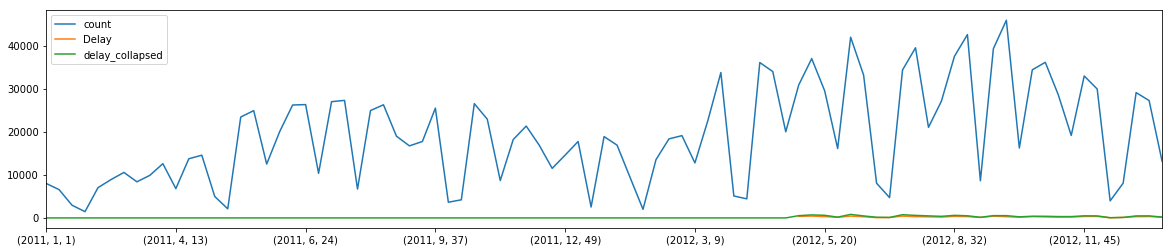

In [18]:
###We see high variability between weeks and seasons but it always increasing as riderships grows

trainByWeek.plot(figsize=(20,4))

plt.show()

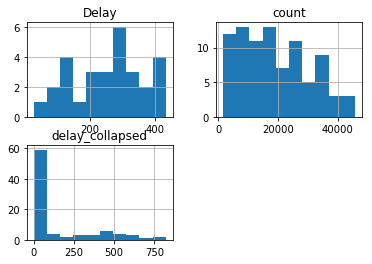

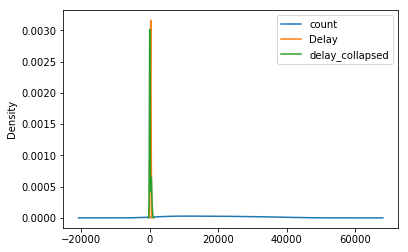

In [19]:
#Reviewing plots of the density of observations can provide further insight into the structure of the data.
#The example below creates a histogram and density plot of the observations without any temporal structure.
trainByWeek.hist()
trainByWeek.plot(kind='kde')
plt.show()

#Some observations from the plots include:
    #The distribution is not Gaussian.
    #The shape has a long right tail and may suggest an exponential distribution. 
    #This lends more support to exploring some power transforms of the data prior to modeling.

In [20]:
########do adfuller to determine stationary of data
# import done in first cell
# from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

##create a list showing the difference between count in a given week in one year vs the previous year. 
##We use dictionaries to access the value from the previous year

date_dictionary={}
for index, row in trainByWeek.iterrows():
    count_value=row['count']
    
    date_dictionary.update({index: count_value})


##take the dictionary items from 2012 and get their corresponding 2011 values for a given week
yearly_difference=[]
for k, v in date_dictionary.items():
    if k[0]==2012:
        #print(k, v)
        this_year_value=v
        last_year=(k[0]-1, k[1], k[2])
        last_year_value=date_dictionary.get(last_year)
        try:
            difference=this_year_value - last_year_value
            
            yearly_difference.append(difference)
        except:
            pass
    else:
        pass
print(len(yearly_difference))        
        


#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(yearly_difference, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)
print("\n The results show that the test statistic value -5.04 is smaller than the critical value at 1% of -3.65. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).")
print("Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.")

41
Results of Dickey-Fuller Test:
Test Statistic                 -5.042102
p-value                         0.000018
#Lags Used                      8.000000
Number of Observations Used    32.000000
Critical Value (1%)            -3.653520
Critical Value (5%)            -2.957219
Critical Value (10%)           -2.617588
dtype: float64

 The results show that the test statistic value -5.04 is smaller than the critical value at 1% of -3.65. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).
Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.


In [21]:
##The next first step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively.
##We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.
# import done in first cell
# from statsmodels.graphics.tsaplots import plot_acf
# from statsmodels.graphics.tsaplots import plot_pacf

#plt.figure()
#plt.subplot(211)
#plot_acf(trainByWeek, ax=plt.gca())
#plt.subplot(212)
#plot_pacf(trainByWeek, ax=plt.gca())
#plt.show()
#print("We see significant lag in the beginning part of the dataset and then it evens out")

In [22]:
# import done in first cell
# from statsmodels.tsa.arima_model import ARIMA

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]


# walk-forward validation
history=[]    
for index, row in trainByWeek.iterrows():
   
    history.append(row['count'] )
devByWeek_list=[]
for index, row in devByWeek.iterrows():
    
    devByWeek_list.append(row['count'] )
            
predictions = list()
for i in range(len(devByWeek_list)):
	# difference data
	
	diff = difference(history)
	# predict
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = devByWeek_list[i]
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))
# report performance
mse = mean_squared_error(devByWeek_list, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)




C:\Users\jorda\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


RMSE: 3680.743


Since Time Series is meant for future prediction and we are not trying to achieve future prediction but instead filling in time gaps where the test data is held out out (ie last week of each month), we are imputing that value to be used in the test set when submitting the notebook to kaggle. The method for imputation is averaging the predicted counts for the 2 weeks prior and 2 weeks post the value we are imputing. This was accomplished in excel through the TS.csv that was generated. The excel file was then turned into Time_Series_formatted.csv after the transformations.

## Merge in Time Series Data

In [23]:
sortedFull["date1"] =[datetime.strptime(i , '%Y-%m-%d') for i in sortedFull["date"] ]
sortedFull.index=sortedFull['date1']


#sortedFull['year'], sortedFull['month'], sortedFull['week'] = sortedFull['date1'].apply(lambda x: x.year), fullWithWMATA['date1'].apply(lambda x: x.month), fullWithWMATA['date1'].apply(lambda x: x.week)
sortedFull['week'] = sortedFull['date1'].dt.week

print(list(sortedFull.columns.values))
Time_Series_formatted=pd.read_csv('~/datasets/bikeshare/Time_Series_formatted.csv')
sortedFull = sortedFull.drop(['date1'])

print(list(Time_Series_formatted.columns.values))

print(list(Time_Series_formatted.columns.values))




###For some reason the year/month/week function puts the beginning days of the year at week 52. This puts it back at week 1
sortedFull.ix[sortedFull.date.isin(['2011-01-01', '2011-01-02', '2011-01-03', '2012-01-01']), 'week']=1


fullWithAll = pd.merge(sortedFull,  Time_Series_formatted,  how='left', left_on=['year', 'week'], right_on=['year', 'week'])


##rename the variable we got from Time series to be more intuitive
fullWithAll.rename(columns={'predictions': 'predictedFromTS'}, inplace=True)
print(list(fullWithAll.columns.values))
fullWithAll.to_csv('~/datasets/bikeshare/merge_test.csv', sep=',')



C:\Users\jorda\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\jorda\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\jorda\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html

['Cause', 'Delay', 'Direction', 'Incident', 'Line', 'atemp', 'casual', 'ceilingHeight', 'count', 'date', 'datetime', 'day', 'dayNum', 'delay_collapsed', 'dewPoint', 'holiday', 'hour', 'humidity', 'isDark', 'isFri', 'isLight', 'isMon', 'isSat', 'isSun', 'isThurs', 'isTrain', 'isTues', 'isTwilight', 'isWeds', 'month', 'registered', 'seaLevelPressure', 'season', 'temp', 'visibilityDistance', 'weather', 'windspeed', 'workingday', 'year', 'yyyymmdd', 'prev_atemp', 'prev_ceilingHeight', 'prev_dewPoint', 'prev_humidity', 'prev_seaLevelPressure', 'prev_temp', 'prev_visibilityDistance', 'prev_weather', 'prev_windspeed', 'date1', 'week']
['year', 'month', 'week', 'predictions']
['year', 'month', 'week', 'predictions']
['Cause', 'Delay', 'Direction', 'Incident', 'Line', 'atemp', 'casual', 'ceilingHeight', 'count', 'date', 'datetime', 'day', 'dayNum', 'delay_collapsed', 'dewPoint', 'holiday', 'hour', 'humidity', 'isDark', 'isFri', 'isLight', 'isMon', 'isSat', 'isSun', 'isThurs', 'isTrain', 'isTues

### Merge in Time Series to test set

In [24]:
sortedTest["date1"] =[datetime.strptime(i , '%Y-%m-%d') for i in sortedTest["date"] ]
sortedTest.index=sortedTest['date1']
print(list(sortedTest.columns.values))

#print(sortedTest)

#sortedTest['year'], sortedTest['month'], sortedTest['week'] = sortedTest['date1'].apply(lambda x: x.year), fullWithWMATA['date1'].apply(lambda x: x.month), fullWithWMATA['date1'].apply(lambda x: x.week)
sortedTest['week'] = sortedTest['date1'].dt.week
Time_Series_formatted=pd.read_csv('~/datasets/bikeshare/Time_Series_formatted.csv')
sortedTest = sortedTest.drop(['date1'])

print(list(Time_Series_formatted.columns.values))

print(list(Time_Series_formatted.columns.values))


###For some reason the year/month/week function puts the beginning days of the year at week 52. This puts it back at week 1
sortedTest.ix[sortedTest.date.isin(['2011-01-01', '2011-01-02', '2011-01-03', '2012-01-01']), 'week']=1


testWithAll = pd.merge(sortedTest,  Time_Series_formatted,  how='left', left_on=['year', 'week'], right_on=['year', 'week'])


##rename the variable we got from Time series to be more intuitive
testWithAll.rename(columns={'predictions': 'predictedFromTS'}, inplace=True)
print(list(testWithAll.columns.values))
testWithAll.to_csv('~/datasets/bikeshare/merge_test.csv', sep=',')



C:\Users\jorda\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\jorda\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\jorda\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html

['Cause', 'Delay', 'Direction', 'Incident', 'Line', 'atemp', 'casual', 'ceilingHeight', 'count', 'date', 'datetime', 'day', 'dayNum', 'delay_collapsed', 'dewPoint', 'holiday', 'hour', 'humidity', 'isDark', 'isFri', 'isLight', 'isMon', 'isSat', 'isSun', 'isThurs', 'isTrain', 'isTues', 'isTwilight', 'isWeds', 'month', 'registered', 'seaLevelPressure', 'season', 'temp', 'visibilityDistance', 'weather', 'windspeed', 'workingday', 'year', 'yyyymmdd', 'prev_atemp', 'prev_ceilingHeight', 'prev_dewPoint', 'prev_humidity', 'prev_seaLevelPressure', 'prev_temp', 'prev_visibilityDistance', 'prev_weather', 'prev_windspeed', 'date1']
['year', 'month', 'week', 'predictions']
['year', 'month', 'week', 'predictions']
['Cause', 'Delay', 'Direction', 'Incident', 'Line', 'atemp', 'casual', 'ceilingHeight', 'count', 'date', 'datetime', 'day', 'dayNum', 'delay_collapsed', 'dewPoint', 'holiday', 'hour', 'humidity', 'isDark', 'isFri', 'isLight', 'isMon', 'isSat', 'isSun', 'isThurs', 'isTrain', 'isTues', 'isTw

## Data Munging

In [25]:
###TURN CATEGORICAL VARIABLES INTO DUMMY VARIABLES

#season: 1 = spring, 2 = summer, 3 = fall, 4 = winter 
fullWithAll['spring']=fullWithAll['season']==1 
#print("Spring vs. season")
#pd.crosstab(fullWithWMATAandTS.spring, fullWithWMATAandTS.season, margins=True)
fullWithAll['summer']=fullWithAll['season']==2
#print("Summer vs. season")
#pd.crosstab(fullWithWMATAandTS.summer, fullWithWMATAandTS.season, margins=True)
print("fall vs. season")
fullWithAll['fall']=fullWithAll['season']==3
pd.crosstab(fullWithAll.fall, fullWithAll.season, margins=True)
print(list(fullWithAll.columns.values))


print("values of holiday", fullWithAll.holiday.unique())
print("values of working day", fullWithAll.workingday.unique())

#Weather: 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
# 2: Mist/Cloudy, Mist/Broken clouds, Mist/Few clouds, Mist 
#3: Light Snow, Light Rain/Thunderstorm /Scattered clouds, Light Rain/Scattered clouds 
#4: Heavy Rain/Ice Pellets/Thunderstorm/Mist, Snow/Fog 
fullWithAll['clearOrPartlyCloudy']=fullWithAll['weather']==1
#print("clear vs. weather")
#pd.crosstab(fullWithWMATAandTS.clearOrPartlyCloudy, fullWithWMATAandTS.weather, margins=True)


fullWithAll['cloudOrMist']=fullWithAll['weather']==2
#print("cloudOrMist vs. weather")
#pd.crosstab(fullWithWMATAandTS.cloudOrMist, fullWithWMATAandTS.weather, margins=True)


fullWithAll['lightRainSnow']=fullWithAll['weather']==3
print("lightRainSnow vs. weather")
pd.crosstab(fullWithAll.lightRainSnow, fullWithAll.weather, margins=True)



try: ##We drop in try/except in case we already ran the code and already dropped
    del fullWithAll['isDark']
    del fullWithAll['isSun']
except KeyError:
    pass
    
                               
#Rescale continous variables to (value - mean )/(max-min)
##save the mean max and min to a dictionary so we can apply these values to the test set. It is the best practice to apply the standardization from the training set values and not the validation set
cols_to_norm = ['temp','atemp', 'humidity', 'windspeed', 'ceilingHeight', 'visibilityDistance',	'dewPoint' , 'seaLevelPressure', 'predictedFromTS', 'prev_atemp', 'prev_ceilingHeight', 'prev_dewPoint', 'prev_humidity', 'prev_seaLevelPressure', 'prev_temp', 'prev_visibilityDistance', 'prev_weather', 'prev_windspeed']



mean_dict={}
max_dict={}
min_dict={}

for var in cols_to_norm:
    newName=var + '_std'
  
    meanValue=fullWithAll[var].mean()
    mean_dict.update({var:meanValue})
    maxValue=fullWithAll[var].max()
    max_dict.update({var:maxValue})
    minValue=fullWithAll[var].min()
    min_dict.update({var:minValue})
    avg = fullWithAll[var].mean()
    diff = maxValue - minValue
    fullWithAll[newName] = fullWithAll[var].apply(lambda x: (x-avg)/diff) 
   
print(mean_dict)
print(max_dict)
print(min_dict)

cols_to_norm_std =([ x + '_std' for x in cols_to_norm ])


for var in cols_to_norm_std:
    print("variable is:", var)
    print("minium value is:", np.min(fullWithAll[var]))
    print("maximum value is:", np.max(fullWithAll[var]))
    print("mean value is:", np.mean(fullWithAll[var]))
    print("\n" *2)   


fall vs. season
['Cause', 'Delay', 'Direction', 'Incident', 'Line', 'atemp', 'casual', 'ceilingHeight', 'count', 'date', 'datetime', 'day', 'dayNum', 'delay_collapsed', 'dewPoint', 'holiday', 'hour', 'humidity', 'isDark', 'isFri', 'isLight', 'isMon', 'isSat', 'isSun', 'isThurs', 'isTrain', 'isTues', 'isTwilight', 'isWeds', 'month_x', 'registered', 'seaLevelPressure', 'season', 'temp', 'visibilityDistance', 'weather', 'windspeed', 'workingday', 'year', 'yyyymmdd', 'prev_atemp', 'prev_ceilingHeight', 'prev_dewPoint', 'prev_humidity', 'prev_seaLevelPressure', 'prev_temp', 'prev_visibilityDistance', 'prev_weather', 'prev_windspeed', 'date1', 'week', 'month_y', 'predictedFromTS', 'spring', 'summer', 'fall']
values of holiday [0 1]
values of working day [0 1]
lightRainSnow vs. weather
{'temp': 20.230859819952173, 'atemp': 23.65508405291192, 'humidity': 61.88645967297446, 'windspeed': 12.799395406945093, 'ceilingHeight': 29938.69704207239, 'visibilityDistance': 15344.963990446446, 'dewPoint':

#### Apply normalization to test set

In [26]:
##We normalize variables in the test set based on the min/max/mean in the train/dev set.
print(list(testWithAll.columns.values))

for var in cols_to_norm:
    print(var)
    avg=mean_dict.get(var)
    maxValue=max_dict.get(var)
    minValue=min_dict.get(var)
    newName=var + '_std'
    diff = maxValue - minValue
    testWithAll[newName] = testWithAll[var].apply(lambda x: (x-avg)/diff) 
    
for var in cols_to_norm_std:
    print("variable is:", var)
    print("minium value is:", np.min(testWithAll[var]))
    print("maximum value is:", np.max(testWithAll[var]))
    print("mean value is:", np.mean(testWithAll[var]))
    print("\n" *2)   
    
    
    
    
    

['Cause', 'Delay', 'Direction', 'Incident', 'Line', 'atemp', 'casual', 'ceilingHeight', 'count', 'date', 'datetime', 'day', 'dayNum', 'delay_collapsed', 'dewPoint', 'holiday', 'hour', 'humidity', 'isDark', 'isFri', 'isLight', 'isMon', 'isSat', 'isSun', 'isThurs', 'isTrain', 'isTues', 'isTwilight', 'isWeds', 'month_x', 'registered', 'seaLevelPressure', 'season', 'temp', 'visibilityDistance', 'weather', 'windspeed', 'workingday', 'year', 'yyyymmdd', 'prev_atemp', 'prev_ceilingHeight', 'prev_dewPoint', 'prev_humidity', 'prev_seaLevelPressure', 'prev_temp', 'prev_visibilityDistance', 'prev_weather', 'prev_windspeed', 'date1', 'week', 'month_y', 'predictedFromTS']
temp
atemp
humidity
windspeed
ceilingHeight
visibilityDistance
dewPoint
seaLevelPressure
predictedFromTS
prev_atemp
prev_ceilingHeight
prev_dewPoint
prev_humidity
prev_seaLevelPressure
prev_temp
prev_visibilityDistance
prev_weather
prev_windspeed
variable is: temp_std
minium value is: -0.483097556495
maximum value is: 0.4964942802

In [27]:
####recut the training and dev set with the new variables
train = fullWithAll[msk]
dev=fullWithAll[~msk]
print("Full dataset shape:", fullWithAll.shape)
print("Train shape:", train.shape)
print("Dev shape:", dev.shape)

Full dataset shape: (10886, 75)
Train shape: (8715, 75)
Dev shape: (2171, 75)


## Random Forest

Below we implement a random forest algorithm after experimenting briefly with an SVR model and ridge regression. We took the algorithm to a 64 core cloud machine to run for several hours to find the optimal hyper parameters. However, the model did not perform the same when taken back to the local desktop despite having the same seed. It is probably due to OS differences. At any rate, we notice that there is a large difference in accuracy between the training and dev set. This is a sign of overfitting. We attempted to separate out the casual and registered variables and then add them together. We made attempts to curtail the overfitting by pruning the trees but were unsuccessful. According to kaggle, we could not get the RMSE below 1.01, which did not beat our baseline of 0.85. 

In [28]:
print(list(fullWithAll.columns.values))




other_vars=['season' , 'holiday', 'workingday', 'weather', 'year', 'delay_collapsed' ,  'isFri', 'isLight', 'isMon', 'isSat', 'isThurs', 'isTrain', 'isTues', 'isTwilight', 'isWeds', 'month_x' ]




X_vars=cols_to_norm_std + other_vars


Y = fullWithAll['count'].values
X = fullWithAll[X_vars]

###Make sure we don't have any null values which would mess up our random forest

X.isnull().any()


['Cause', 'Delay', 'Direction', 'Incident', 'Line', 'atemp', 'casual', 'ceilingHeight', 'count', 'date', 'datetime', 'day', 'dayNum', 'delay_collapsed', 'dewPoint', 'holiday', 'hour', 'humidity', 'isFri', 'isLight', 'isMon', 'isSat', 'isThurs', 'isTrain', 'isTues', 'isTwilight', 'isWeds', 'month_x', 'registered', 'seaLevelPressure', 'season', 'temp', 'visibilityDistance', 'weather', 'windspeed', 'workingday', 'year', 'yyyymmdd', 'prev_atemp', 'prev_ceilingHeight', 'prev_dewPoint', 'prev_humidity', 'prev_seaLevelPressure', 'prev_temp', 'prev_visibilityDistance', 'prev_weather', 'prev_windspeed', 'date1', 'week', 'month_y', 'predictedFromTS', 'spring', 'summer', 'fall', 'clearOrPartlyCloudy', 'cloudOrMist', 'lightRainSnow', 'temp_std', 'atemp_std', 'humidity_std', 'windspeed_std', 'ceilingHeight_std', 'visibilityDistance_std', 'dewPoint_std', 'seaLevelPressure_std', 'predictedFromTS_std', 'prev_atemp_std', 'prev_ceilingHeight_std', 'prev_dewPoint_std', 'prev_humidity_std', 'prev_seaLevel

temp_std                       False
atemp_std                      False
humidity_std                   False
windspeed_std                  False
ceilingHeight_std              False
visibilityDistance_std         False
dewPoint_std                   False
seaLevelPressure_std           False
predictedFromTS_std            False
prev_atemp_std                 False
prev_ceilingHeight_std         False
prev_dewPoint_std              False
prev_humidity_std              False
prev_seaLevelPressure_std      False
prev_temp_std                  False
prev_visibilityDistance_std    False
prev_weather_std               False
prev_windspeed_std             False
season                         False
holiday                        False
workingday                     False
weather                        False
year                           False
delay_collapsed                False
isFri                          False
isLight                        False
isMon                          False
i

In [29]:
other_vars=['season' , 'holiday', 'workingday', 'weather', 'year', 'delay_collapsed' ,  'isFri', 'isLight', 'isMon', 'isSat', 'isThurs', 'isTrain', 'isTues', 'isTwilight', 'isWeds', 'month_x' ]


X_vars=cols_to_norm_std + other_vars
Y = fullWithAll['casual'].values
X = fullWithAll[X_vars].values

cv = cross_validation.ShuffleSplit(len(X), n_iter=3, test_size=0.2,
    random_state=401)

print ("SVR(kernel='rbf',C=10,gamma=.001)")
for train, dev in cv:
    
    svc = svm.SVR(kernel ='rbf', C = 10, gamma = .001).fit(X[train], Y[train])
    print("train score: {0:.3f}, dev score: {1:.3f}\n".format(
        svc.score(X[train], Y[train]), svc.score(X[dev], Y[dev])))

print ("Ridge"  )  
for train, dev in cv:    
    svc = linear_model.Ridge().fit(X[train], Y[train])
    print("train score: {0:.3f}, dev score: {1:.3f}\n".format(
        svc.score(X[train], Y[train]), svc.score(X[dev], Y[dev])))
    
print ("Random Forest(n_estimators = 100)"   ) 
for train, dev in cv:    
    svc = RandomForestRegressor(n_estimators = 100).fit(X[train], Y[train])
    print("train score: {0:.3f}, dev score: {1:.3f}\n".format(
        svc.score(X[train], Y[train]), svc.score(X[dev], Y[dev])))
    


SVR(kernel='rbf',C=10,gamma=.001)
train score: 0.236, dev score: 0.254

train score: 0.238, dev score: 0.236

train score: 0.237, dev score: 0.270

Ridge
train score: 0.532, dev score: 0.531

train score: 0.529, dev score: 0.540

train score: 0.535, dev score: 0.513

Random Forest(n_estimators = 100)
train score: 0.979, dev score: 0.856

train score: 0.979, dev score: 0.857

train score: 0.981, dev score: 0.827



In [30]:
###Random forest was the best so let's tune that




#####We executed the following code on a 64 core Virtual Server to train the best random forest outcome. We leave it here but commented out to show 
##what we did. 
# Set the parameters by cross-validation

#Commented out code block:
#################################################################################################################################
#
#tuned_parameters = {'n_estimators': [ 50, 100, 150, 200,  500, 750, 1000], 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100], 'min_samples_split': [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100]}
#
#
#clf = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=10,  n_jobs=-1, verbose=1)
#clf.fit(X[train], Y[train])
#
#clf.fit(X, Y)
#print("casual")
#print (clf.best_estimator_)
########################################################################################################3


###Results of the gridsearch are below from 13,700 fits in 190 minutes on 64 cores.

#RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
          # max_features='auto', max_leaf_nodes=None,
          # min_impurity_decrease=0.0, min_impurity_split=None,
          # min_samples_leaf=1, min_samples_split=15,
          # min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
         #  oob_score=False, random_state=None, verbose=0, warm_start=False)


In [31]:
other_vars=['season' , 'holiday', 'workingday', 'weather', 'year', 'delay_collapsed' ,  'isFri', 'isLight', 'isMon', 'isSat', 'isThurs', 'isTrain', 'isTues', 'isTwilight', 'isWeds', 'month_x' ]


X_vars=cols_to_norm_std + other_vars
Y = fullWithAll['registered'].values
X = fullWithAll[X_vars].values

cv = cross_validation.ShuffleSplit(len(X), n_iter=3, test_size=0.2,
    random_state=401)

print ("SVR(kernel='rbf',C=10,gamma=.001)")
for train, dev in cv:
    
    svc = svm.SVR(kernel ='rbf', C = 10, gamma = .001).fit(X[train], Y[train])
    print("train score: {0:.3f}, dev score: {1:.3f}\n".format(
        svc.score(X[train], Y[train]), svc.score(X[dev], Y[dev])))

print ("Ridge"  )  
for train, dev in cv:    
    svc = linear_model.Ridge().fit(X[train], Y[train])
    print("train score: {0:.3f}, dev score: {1:.3f}\n".format(
        svc.score(X[train], Y[train]), svc.score(X[dev], Y[dev])))
    
print ("Random Forest(n_estimators = 100)"   ) 
for train, dev in cv:    
    svc = RandomForestRegressor(n_estimators = 100).fit(X[train], Y[train])
    print("train score: {0:.3f}, dev score: {1:.3f}\n".format(
        svc.score(X[train], Y[train]), svc.score(X[dev], Y[dev])))
    


SVR(kernel='rbf',C=10,gamma=.001)
train score: 0.197, dev score: 0.198

train score: 0.188, dev score: 0.198

train score: 0.197, dev score: 0.205

Ridge
train score: 0.431, dev score: 0.418

train score: 0.423, dev score: 0.450

train score: 0.433, dev score: 0.408

Random Forest(n_estimators = 100)
train score: 0.948, dev score: 0.600

train score: 0.946, dev score: 0.642

train score: 0.948, dev score: 0.586



In [32]:





#####We executed the following code on a 64 core Virtual Server to train the best random forest outcome. We leave it here but commented out to show 
##what we did. 
# Set the parameters by cross-validation

#Commented out code block:
#################################################################################################################################
#
#tuned_parameters = {'n_estimators': [ 50, 100, 150, 200,  500, 750, 1000], 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100], 'min_samples_split': [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100]}
#
#
#clf = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=10,  n_jobs=-1, verbose=1)
#clf.fit(X[train], Y[train])
#
#clf.fit(X, Y)
#print("registered")
#print (clf.best_estimator_)
########################################################################################################3


###Results of the gridsearch are below from 13,700 fits in 211 minutes on 64 cores.

#RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           #max_features='auto', max_leaf_nodes=None,
           #min_impurity_decrease=0.0, min_impurity_split=None,
           #min_samples_leaf=1, min_samples_split=10,
           #min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           #oob_score=False, random_state=None, verbose=0, warm_start=False)


In [81]:
####Finalize random forest on casual



cv = cross_validation.ShuffleSplit(len(X), n_iter=4, test_size=0.2,
    random_state=401)





Y = fullWithAll['casual'].values





testSetForest= testWithAll[X_vars].values





for train, dev in cv:
    

    svc = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           
           min_samples_leaf=1, min_samples_split=15,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False).fit(X[train], Y[train])
    
    print("train score: {0:.3f}, dev score: {1:.3f}\n".format(
        svc.score(X[train], Y[train]), svc.score(X[dev], Y[dev])))
    
    
    



    
preds_casual=svc.predict(testSetForest)    


train score: 0.736, dev score: 0.708

train score: 0.736, dev score: 0.709

train score: 0.750, dev score: 0.696

train score: 0.742, dev score: 0.742



In [82]:
####Finalize random forest on registered



cv = cross_validation.ShuffleSplit(len(X), n_iter=2, test_size=0.2,
    random_state=401)





Y = fullWithAll['registered'].values





testSetForest= testWithAll[X_vars].values





for train, dev in cv:
    

    svc = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False).fit(X[train], Y[train])
    svc=RandomForestRegressor(n_estimators = 100).fit(X[train], Y[train])
    print("train score: {0:.3f}, dev score: {1:.3f}\n".format(
        svc.score(X[train], Y[train]), svc.score(X[dev], Y[dev])))
    
    
    



    
preds_registered=svc.predict(testSetForest)    





train score: 0.948, dev score: 0.598

train score: 0.946, dev score: 0.648



In [84]:


datetime=test['datetime']

print(type(datetime))

test2 = list(zip(datetime,preds_casual, preds_registered))
zipped_list = test2[:]
zipped_list_2 = list(test2)



submission = pd.DataFrame(zipped_list_2)
submission.columns = ['datetime', 'casual', 'registered']

submission['count'] = submission['casual'] + submission['registered']

submission=submission.drop(['casual', 'registered'], axis=1)

submission = submission.set_index('datetime')
submission['count'] = submission['count'].apply(lambda x: round(x,0))
submission['count']
print(submission)
#print(submission)
submission.to_csv('~/datasets/bikeshare/random_forest.csv', sep=',')

<class 'pandas.core.series.Series'>
                     count
datetime                  
2011-01-20 00:00:00   19.0
2011-01-20 01:00:00   37.0
2011-01-20 02:00:00   33.0
2011-01-20 03:00:00   27.0
2011-01-20 04:00:00   26.0
2011-01-20 05:00:00   36.0
2011-01-20 06:00:00   78.0
2011-01-20 07:00:00  134.0
2011-01-20 08:00:00   81.0
2011-01-20 09:00:00   68.0
2011-01-20 10:00:00   77.0
2011-01-20 11:00:00   80.0
2011-01-20 12:00:00  101.0
2011-01-20 13:00:00   88.0
2011-01-20 14:00:00  107.0
2011-01-20 15:00:00  107.0
2011-01-20 16:00:00   90.0
2011-01-20 17:00:00  137.0
2011-01-20 18:00:00  106.0
2011-01-20 19:00:00   49.0
2011-01-20 20:00:00   55.0
2011-01-20 21:00:00   37.0
2011-01-20 22:00:00   22.0
2011-01-20 23:00:00   13.0
2011-01-21 00:00:00   17.0
2011-01-21 01:00:00   14.0
2011-01-21 02:00:00   25.0
2011-01-21 03:00:00   22.0
2011-01-21 04:00:00   40.0
2011-01-21 05:00:00   45.0
...                    ...
2012-12-30 18:00:00  262.0
2012-12-30 19:00:00  220.0
2012-12-30 20:00:00

# Linear Regression Analyses

In [70]:
#Datasets:
#sortedFull
#sortedTest

titles = list(sortedFull.columns.values)
print(sortedFull.shape)
print(sortedTest.shape)

sortedFull=sortedFull.fillna(0)
sortedTest=sortedTest.fillna(0)

# Split Full into datetime, train and dev (if dataset changes, this is the last piece of code that will need updating)
full_data = sortedFull
test_data = sortedTest
train_data = sortedFull.iloc[:-1000, :]
dev_data = sortedFull.iloc[-1000:, :]
datetime = test['datetime']

# Split train and dev into training/dev data and training/dev labels

train_labels = train_data['count'].values
train_data = train_data.drop(['Cause', 'Direction', 'Incident', 'Line', 'date', 'datetime', 'count', 'casual', 'registered'], axis = 1)
dev_labels = dev_data['count'].values
dev_data = dev_data.drop(['Cause', 'Direction', 'Incident', 'Line', 'date', 'datetime', 'count', 'casual', 'registered'], axis = 1)
train_data_titles = list(train_data.columns.values)
test_data = test_data.drop(['Cause', 'Direction', 'Incident', 'Line', 'date', 'datetime', 'count', 'casual', 'registered'], axis = 1)

# Verify the shapes are what we want...
print(train_labels.shape)
print(train_data.shape)
print(dev_labels.shape)
print(dev_data.shape)


# Stats Model OLS
ordin = sm.OLS(train_labels, train_data)
ordin2 = ordin.fit()
print(ordin2.summary())

# Linear Regression:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(train_data, train_labels)
coefficients = lin_reg.coef_

lin_pred = lin_reg.predict(dev_data)
  
print()
print("===========================================")   
print('Linear Regression Error - RMSLE:', rmsle(dev_labels, lin_pred))
print("===========================================") 

# Let's try Lasso:
alpha = [0.1, 1, 2, 3, 4, 10, 30]
best_alpha = 0
best_rmsle = 100

for i in range(7):
    lasso_reg = linear_model.Lasso(alpha = alpha[i])
    lasso_reg.fit(train_data, train_labels)
    lasso_pred = lasso_reg.predict(dev_data)
    error = rmsle(dev_labels, lasso_pred)

    if error < best_rmsle:
        best_rmsle = error
        best_alpha = alpha[i]

print('Lasso Regression - Best alpha is:', best_alpha, 'with an RMSLE of:', best_rmsle)
print("===========================================") 

lasso_reg = linear_model.Lasso(alpha = 0.1)
lasso_reg.fit(train_data, train_labels)
lasso_pred = lasso_reg.predict(test_data)

submission = pd.DataFrame({
        "datetime": datetime,
        "count": [max(0, x) for x in total_test_count]
    })
submission = submission.set_index('datetime')
submission.to_csv('~/datasets/bikeshare/lasso_reg_result.csv', sep=',')

(10886, 49)
(6493, 49)
(9886,)
(9886, 40)
(1000,)
(1000, 40)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     368.1
Date:                Sun, 20 Aug 2017   Prob (F-statistic):               0.00
Time:                        16:22:27   Log-Likelihood:                -61210.
No. Observations:                9886   AIC:                         1.225e+05
Df Residuals:                    9850   BIC:                         1.228e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------

C:\Users\talt\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


Lasso Regression - Best alpha is: 0.1 with an RMSLE of: 1.03146061872


In [27]:
# Now lets do Logistic Regression, L2
c_list = [0.05, 0.1, 0.25, 0.5, 1, 10]
best_c = 0
best_rmsle = 100

#log_reg = LogisticRegression(C = 0.05, penalty='l2')
#log_reg.fit(train_data, train_labels)
#log_pred = log_reg.predict(dev_data)
#error = rmsle(dev_labels, log_pred)


for c in range(len(c_list)):
    log_reg = LogisticRegression(C = c_list[c], penalty='l2')
    log_reg.fit(train_data, train_labels)
    log_pred = log_reg.predict(dev_data)
    error = rmsle(dev_labels, log_pred)
    if error < best_rmsle:
        best_rmsle = error
        best_c = c_list[c]
    print('For C = ', c_list[c], ', RMSLE = ', error, '.')

   
   
print("===========================================") 
print('L2 Logistic Regression - Best C is:', best_c, 'with an RMSLE of:', error)
print("===========================================") 

For C =  0.05 , RMSLE =  3.35617521332 .
For C =  0.1 , RMSLE =  3.3296831453 .
For C =  0.25 , RMSLE =  3.35622622579 .
For C =  0.5 , RMSLE =  3.3544636212 .
For C =  1 , RMSLE =  3.35181341769 .
For C =  10 , RMSLE =  3.35358127309 .
L2 Logistic Regression - Best C is: 0.1 with an RMSLE of: 3.35358127309


In [68]:
# Since Linear and Lasso Regressions yielded the best RMSLE, let's use these to
# try separating casual and registered riders into two models,
# generate a regression on each, then combine the results.
# Casual and Registered Riders are independent of each other, and the variables would affect these riders separately.
# Let's see if a regression using two different models (casual and registered) improves our error.

# Split train and dev into training/dev data and training/dev labels
full_data = sortedFull
test_data = sortedTest
train_data = sortedFull.iloc[:-1000, :]
dev_data = sortedFull.iloc[-1000:, :]
datetime = test['datetime']

full_data = full_data.drop(['Cause', 'Direction', 'Incident', 'Line', 'date', 'datetime', 'count', 'casual', 'registered'], axis = 1)
test_data = test_data.drop(['Cause', 'Direction', 'Incident', 'Line', 'date', 'datetime', 'count', 'casual', 'registered'], axis = 1)

casual_train_labels = train_data['casual'].values
registered_train_labels = train_data['registered'].values
train_data = train_data.drop(['Cause', 'Direction', 'Incident', 'Line', 'date', 'datetime', 'count', 'casual', 'registered'], axis = 1)

dev_casual_labels = dev_data['casual'].values
dev_registered_labels = dev_data['registered'].values
dev_data = dev_data.drop(['Cause', 'Direction', 'Incident', 'Line', 'date', 'datetime', 'count', 'casual', 'registered'], axis = 1)
train_data_titles = list(train_data.columns.values)

# Linear Regression:
casual_lin_reg = linear_model.LinearRegression()
casual_lin_reg.fit(train_data, casual_train_labels)
casual_coefficients = casual_lin_reg.coef_
casual_lin_pred = casual_lin_reg.predict(dev_data)

registered_lin_reg = linear_model.LinearRegression()
registered_lin_reg.fit(train_data, registered_train_labels)
registered_coefficients = registered_lin_reg.coef_
registered_lin_pred = registered_lin_reg.predict(dev_data)

total_count = [casual_lin_pred[i]+registered_lin_pred[i] for i in range(len(registered_lin_pred))]

print()
print("===========================================")   
print('Linear Regression Error - RMSLE:', rmsle(dev_labels, total_count))
print("===========================================") 

# Perform predictions on the whole dataset
# Linear Regression:
casual_test_pred = casual_lin_reg.predict(test_data)
registered_test_pred = registered_lin_reg.predict(test_data)

total_test_count = [casual_test_pred[i]+registered_test_pred[i] for i in range(len(registered_test_pred))]

submission = pd.DataFrame({
        "datetime": datetime,
        "count": [max(0, x) for x in total_test_count]
    })
submission = submission.set_index('datetime')
submission.to_csv('~/datasets/bikeshare/lin_reg_combined_result.csv', sep=',')




Linear Regression Error - RMSLE: 1.03195203476


In [77]:
# Let's transform and remove some variables that do not have a statistical significance:

# Split Full into datetime, train and dev (if dataset changes, this is the last piece of code that will need updating)
full_data = sortedFull
test_data = sortedTest
train_data = sortedFull.iloc[:-1000, :]
dev_data = sortedFull.iloc[-1000:, :]
datetime = test['datetime']

# Split train and dev into training/dev data and training/dev labels

train_labels = train_data['count'].values
train_data = train_data.drop(['Cause', 'Direction', 'Incident', 'Line', 'date', 'datetime', 'count', 'casual', 'registered'], axis = 1)
dev_labels = dev_data['count'].values
dev_data = dev_data.drop(['Cause', 'Direction', 'Incident', 'Line', 'date', 'datetime', 'count', 'casual', 'registered'], axis = 1)
train_data_titles = list(train_data.columns.values)
test_data = test_data.drop(['Cause', 'Direction', 'Incident', 'Line', 'date', 'datetime', 'count', 'casual', 'registered'], axis = 1)

# Transforming delay into minutes (since data is provided hourly...let's see if this normalization helps)
full_data.loc[:,'delay_collapsed'] *= 0.016667
test_data.loc[:, 'delay_collapsed'] *= 0.016667




print('success')

success


# Neural Net Analysis

In [ ]:
#####################################################
# We want to use Neural Nets to identify new features
# as well as to predict ridership
# Starting point is to use Theano1 workbook to run a simple LR and see how the 
# results compare to above
#
# Then move on to testing with 1, 2 and 3 hidden layers and some varying of the number of hidden nodes
# Having some trouble getting started with Theano ... will be posting on Slack and may be emailing you
# for help, if possible.
#######################################################

# Final Analysis

In [ ]:
#######################################################
# Generate an LR based on the best OLS results, the TS results and the Neural Net results
# Hoping that the strenths and weaknesses of each approach balance each other out and we get a better 
# submission result.
# Create a submission for Kaggle
#####################################################